<a href="https://colab.research.google.com/github/ritwiks9635/CNN_Project_File/blob/main/Aerial_Image_Segmentation_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Aerial-Image-Segmentation-with-PyTorch**

#**About Dataset**

###**Dataset**

Here the dataset which we are going to use in this guided project is the subset(200 images and its masks) of the original dataset (Massachusetts Roads Dataset) consists of 1171 aerial images of the state of Massachusetts. Each image is 1500×1500 pixels in size, covering an area of 2.25 square kilometers

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

In [2]:
!git clone https://github.com/parth1620/Road_seg_dataset.git

Cloning into 'Road_seg_dataset'...
remote: Enumerating objects: 411, done.
remote: Total 411 (delta 0), reused 0 (delta 0), pack-reused 411
Receiving objects: 100% (411/411), 851.74 MiB | 10.82 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (401/401), done.


#**Some Common Imports**

In [3]:
import sys
sys.path.append('/content/Road_seg_dataset')

In [4]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

In [5]:
CSV_FILE = '/content/Road_seg_dataset/train.csv'
DATA_DIR = '/content/Road_seg_dataset/'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
BATCH_SIZE = 8
IMG_SIZE = 512

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [6]:
data = pd.read_csv(CSV_FILE)
data.head()

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png


In [7]:
idx = 10

row = data.iloc[idx]
image_path = DATA_DIR + row.images
mask_path = DATA_DIR + row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

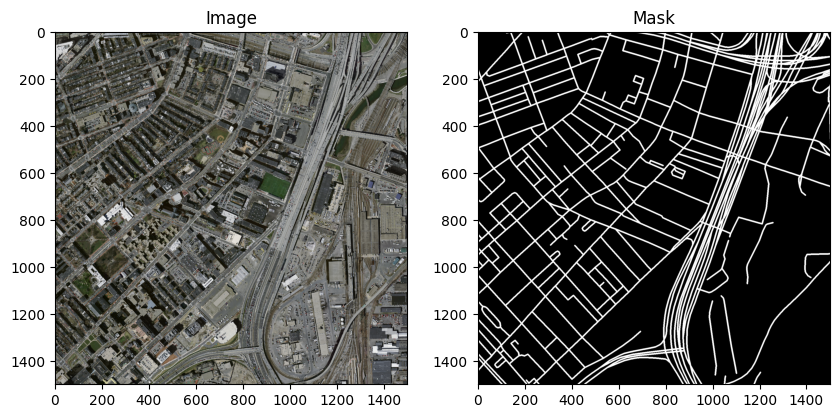

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))

ax1.set_title("Image")
ax1.imshow(image)

ax2.set_title("Mask")
ax2.imshow(mask, cmap = "gray")

In [9]:
train_data, valid_data = train_test_split(data, test_size = 0.2, random_state = 42)
len(train_data), len(valid_data)

(159, 40)

#**Augmentation Functions**
albumentation documentation : https://albumentations.ai/docs/

In [10]:
import albumentations as A

In [11]:
def get_train_augs():
    return A.Compose(
        [
          A.Resize(IMG_SIZE, IMG_SIZE),
          A.HorizontalFlip(p = 0.5),
          A.VerticalFlip(p = 0.5)
        ])

def get_valid_augs():
    return A.Compose(
        [
          A.Resize(IMG_SIZE, IMG_SIZE)
        ])

#**Create Custom Dataset**

In [12]:
class SegmentationDataset(torch.utils.data.Dataset):
    def __init__(self, data, augmentation):
        self.data = data
        self.augmentation = augmentation

    def __len__(self):
       return len(self.data)

    def __getitem__(self, idx):

        row = self.data.iloc[idx]
        image_path = DATA_DIR + row.images
        mask_path = DATA_DIR + row.masks

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = np.expand_dims(mask, axis = -1)

        if self.augmentation:
            data = self.augmentation(image = image, mask = mask)
            image = data["image"]
            mask = data["mask"]

        image = np.transpose(image, (2, 0, 1)).astype("float32")
        mask = np.transpose(mask, (2, 0, 1)).astype("float32")

        image = torch.Tensor(image) / 255.0
        mask  = torch.round(torch.Tensor(mask) / 255.0)

        return image, mask

In [13]:
trainset = SegmentationDataset(train_data, get_train_augs())
validset = SegmentationDataset(valid_data, get_valid_augs())

In [14]:
len(trainset), len(validset)

(159, 40)

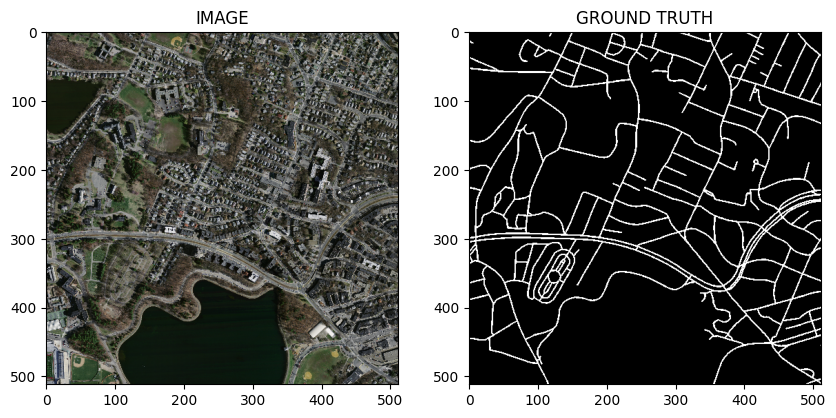

In [15]:
idx = 9

image, mask = trainset[idx]

helper.show_image(image, mask)

#**Load dataset into batches**

In [16]:
from torch.utils.data import DataLoader

trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [17]:
print(f'total no. of batches in trainloader : {len(trainloader)}')
print(f'total no. of batches in validloader : {len(validloader)}')

total no. of batches in trainloader : 20
total no. of batches in validloader : 5


In [18]:
for image, mask in trainloader:
    print("Total image shape :: ", image.shape)
    print("Total mask shape :: ", mask.shape)
    break

Total image shape ::  torch.Size([8, 3, 512, 512])
Total mask shape ::  torch.Size([8, 1, 512, 512])


#**Create Segmentation Model**
segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [19]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [20]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.backbone = smp.Unet(
            encoder_name=ENCODER,
            encoder_weights=WEIGHTS,
            in_channels=3,
            classes=1,
            activation=None # output will be raw
    )

  def forward(self, images, masks=None):
    logits = self.backbone(images)

    if masks != None:
      return logits, DiceLoss(mode='binary')(logits, masks) + nn.BCEWithLogitsLoss()(logits, masks)

    return logits

In [21]:
model = SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 114MB/s] 


SegmentationModel(
  (backbone): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
      

#**Create Train and Validation Function**

In [22]:
def train_fn(data_loader: DataLoader, model: SegmentationModel, optimizer):
  model.train() # to turn ON dropout, batchnorm, etc.
  total_loss = 0.0

  for images, masks in tqdm(data_loader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward() # calc gradient
    optimizer.step()  # update parameters

    total_loss += loss.item()

  return total_loss / len(data_loader)  # divide by number of batch

In [23]:
def eval_fn(data_loader: DataLoader, model: SegmentationModel):
  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)

      total_loss += loss.item()

    return total_loss / len(data_loader)

In [24]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [25]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt') # .pt = pytorch
    print('SAVED-MODEL')
    best_valid_loss = valid_loss

  print('Epoch: %d -- train_loss: %f -- valid_loss: %f'%(i+1, train_loss, valid_loss))

100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


SAVED-MODEL
Epoch: 1 -- train_loss: 1.229659 -- valid_loss: 1.046665


100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


SAVED-MODEL
Epoch: 2 -- train_loss: 0.791009 -- valid_loss: 0.844871


100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


SAVED-MODEL
Epoch: 3 -- train_loss: 0.716459 -- valid_loss: 0.728953


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Epoch: 4 -- train_loss: 0.669751 -- valid_loss: 0.746518


100%|██████████| 5/5 [00:03<00:00,  1.27it/s]


SAVED-MODEL
Epoch: 5 -- train_loss: 0.655038 -- valid_loss: 0.686311


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Epoch: 6 -- train_loss: 0.645919 -- valid_loss: 0.733971


100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


Epoch: 7 -- train_loss: 0.633902 -- valid_loss: 0.698198


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


SAVED-MODEL
Epoch: 8 -- train_loss: 0.617499 -- valid_loss: 0.676794


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


SAVED-MODEL
Epoch: 9 -- train_loss: 0.618627 -- valid_loss: 0.655307


100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


SAVED-MODEL
Epoch: 10 -- train_loss: 0.613725 -- valid_loss: 0.643676


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


SAVED-MODEL
Epoch: 11 -- train_loss: 0.605425 -- valid_loss: 0.632786


100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


Epoch: 12 -- train_loss: 0.611575 -- valid_loss: 0.693582


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Epoch: 13 -- train_loss: 0.610638 -- valid_loss: 0.686496


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Epoch: 14 -- train_loss: 0.606812 -- valid_loss: 0.638945


100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


Epoch: 15 -- train_loss: 0.587352 -- valid_loss: 0.648850


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Epoch: 16 -- train_loss: 0.581764 -- valid_loss: 0.657163


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Epoch: 17 -- train_loss: 0.580732 -- valid_loss: 0.690578


100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Epoch: 18 -- train_loss: 0.575373 -- valid_loss: 0.656793


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


SAVED-MODEL
Epoch: 19 -- train_loss: 0.574024 -- valid_loss: 0.600231


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Epoch: 20 -- train_loss: 0.564898 -- valid_loss: 0.674184


100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


Epoch: 21 -- train_loss: 0.567071 -- valid_loss: 0.639335


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


Epoch: 22 -- train_loss: 0.562274 -- valid_loss: 0.621375


100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Epoch: 23 -- train_loss: 0.560417 -- valid_loss: 0.629166


100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch: 24 -- train_loss: 0.567436 -- valid_loss: 0.661294


100%|██████████| 5/5 [00:04<00:00,  1.20it/s]

Epoch: 25 -- train_loss: 0.571546 -- valid_loss: 0.670798


In [26]:
idx = 30

model.load_state_dict(torch.load('/content/best_model.pt'))
image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0))  # (c, h, w) -> (b, c, h, w) ~ batch_size(b)=1
pred_mask = torch.sigmoid(logits_mask)
pre_mask = (pred_mask > 0.5)*1.0

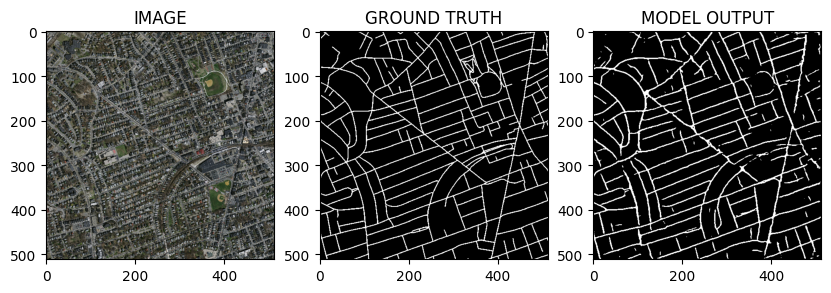

In [27]:
helper.show_image(image, mask, pre_mask.detach().cpu().squeeze(0))

In [ ]:
# all model names
#import timm
#timm.list_models('*')